# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install ./python
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis.x86_64",no_graphics=False)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space

vector_names = ['racket x pos     ', 'racket y pos     ', 'racket x velocity', 'racket y velocity',
                'ball   x pos     ', 'ball   y pos     ', 'ball   x velocity', 'ball   y velocity']
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print(vector_names)
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
['racket x pos     ', 'racket y pos     ', 'racket x velocity', 'racket y velocity', 'ball   x pos     ', 'ball   y pos     ', 'ball   x velocity', 'ball   y velocity']
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.09000000171363354
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
import torch
from collections import deque
import time
import matplotlib.pyplot as plt
%matplotlib inline 

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):

    fan_in = layer.weight.data.size()[0]
    lim = np.sqrt(1.0/fan_in)# lim = (1/N)**0.5 where N is the number of units in the layer

    return [-lim, lim]

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """

        super(Actor, self).__init__()

        self.seed = torch.manual_seed(seed) # random seed
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_units = [128,128]

        # Layers
        self.fc1 = nn.Linear(self.state_size, self.hidden_units[0])
        self.fc2 = nn.Linear(self.hidden_units[0], self.hidden_units[1])
        self.fc3 = nn.Linear(self.hidden_units[1], self.action_size)

        self.reset_parameters()

    def reset_parameters(self):
        """ Initializing weights """

        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Building an actor (policy) network that maps states -> actions."""

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))

        return x



class Critic(nn.Module):

    def __init__(self, state_size, action_size, num_agents, seed):
        """Initializing parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """

        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed) # set random seed
        self.state_size = state_size
        self.action_size = action_size
        self.all_state_size = state_size * num_agents
        self.all_action_size = action_size * num_agents
        self.hidden_units = [256, 128]

        # Layers
        self.fc1 = nn.Linear(self.all_state_size + self.all_action_size, self.hidden_units[0])
        self.fc2 = nn.Linear(self.hidden_units[0], self.hidden_units[1])
        self.fc3 = nn.Linear(self.hidden_units[1], 1)

        self.reset_parameters()

    def reset_parameters(self):

        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, all_state, all_action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""

        sa_flat = all_state.view(-1, self.all_state_size) # reshape can return either a copy or a view of the original tensor
        aa_flat = all_action.view(-1, self.all_action_size)
        x = torch.cat([sa_flat, aa_flat], dim = 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [9]:
import copy
from collections import deque, namedtuple

class OUNoise():
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu = 0.0, theta = 0.15, sigma = 0.2): # 0.0, 0.15, 0.4

        self.seed = random.seed(seed)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma

        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx

        return self.state

class ReplayBuffer():
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed = 31):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """

        self.seed = random.seed(seed) # set random seed
        self.buffer_size = buffer_size # buffer size
        self.batch_size = batch_size # batch size
        self.memory = deque(maxlen = self.buffer_size) # internal memory (deque)

        field_names = ['all_state', 'all_action', 'all_reward', 'all_next_state', 'all_done']
        self.experience = namedtuple("Experience", field_names = field_names)

    def add(self, all_state, all_action, all_reward, all_next_state, all_done):

        e = self.experience(all_state, all_action, all_reward, all_next_state, all_done)
        self.memory.append(e)

    def sample(self, agent_num):

        experiences = random.sample(self.memory, k = self.batch_size)

        states = torch.from_numpy(np.vstack([e.all_state[agent_num] for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.all_action[agent_num] for e in experiences if e is not None])).float()
        rewards = torch.from_numpy(np.vstack([e.all_reward[agent_num] for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.all_next_state[agent_num] for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.all_done[agent_num] for e in experiences if e is not None]).astype(np.uint8)).float()
        all_states = torch.from_numpy(np.vstack([[e.all_state] for e in experiences if e is not None])).float()
        all_actions = torch.from_numpy(np.vstack([[e.all_action] for e in experiences if e is not None])).float()
        all_next_states = torch.from_numpy(np.vstack([[e.all_next_state] for e in experiences if e is not None])).float()

        return (states, all_states, actions, all_actions, rewards, next_states, all_next_states, dones)

    def __len__(self):

        return len(self.memory)


In [10]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Hyper Parameters
GAMMA = 0.998
TAU =  0.1 
LR_ACTOR = 0.0001 
LR_CRITIC = 0.001 
BUFFER_SIZE = 100000 
BATCH_SIZE = 256 
UPDATE_EVERY = 1 
NUM_LEARNING = 1 # how often the updates are done for each learning
WEIGHT_DECAY_ACTOR = 0.0 
WEIGHT_DECAY_CRITIC = 0.0 

EPSILON = 1.0 # initial scale factor for noise

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DDPG_Agent():
    """
    This module defines a DDPG agent (both actor and critic models).

    """

    def __init__(self, state_size, action_size, num_agents, seed):
        """
        Initialize an Agent object.
        
        Params
        ======
        - state_size for an agent: 24
        - size_action for an agent: 2
        - num_agents: 2
        """

        self.seed = torch.manual_seed(seed) # random seed
        self.action_size = action_size
        self.state_size = state_size
        self.num_agents = num_agents
        self.epsilon = EPSILON # scale factor for the noise
        
        # ctor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, seed).to(device)
        self.actor_target = Actor(state_size, action_size, seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr = LR_ACTOR, weight_decay = WEIGHT_DECAY_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, num_agents, seed).to(device)
        self.critic_target = Critic(state_size, action_size, num_agents, seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr = LR_CRITIC, weight_decay = WEIGHT_DECAY_CRITIC)

        # Noise process
        self.noise = OUNoise(action_size, seed)

        # Updating target networks with equal the weights
        self.soft_update(self.actor_local, self.actor_target, 1.0)
        self.soft_update(self.critic_local, self.critic_target, 1.0)

    def act(self, state, add_noise = True):
        """Returns actions for given state as per current policy.


        Params
        - state tensor, with dim = 24 for an agent
        - add_noise

        (output)
        - action tensor, with dim  = 2, for an agent

        """

        state = torch.from_numpy(state).float().to(device)

        # Select an action based on the local actor model policy
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()

        if add_noise == True:
            noise_sample = self.noise.sample() * self.epsilon
            action += noise_sample

        EPSILON_DECAY = 0.999 # decay rate of the scale factor
        EPSILON_MIN = 0.3
        
        # Update the scale factor
        self.epsilon = max(self.epsilon*EPSILON_DECAY, EPSILON_MIN)

        return np.clip(action, -1, 1)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """

        for l_param, t_param in zip(local_model.parameters(), target_model.parameters()):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)


class MADDPG_Agent():

    def __init__(self, state_size, action_size, num_agents, seed):

        self.seed = torch.manual_seed(seed) # random seed
        self.state_size = state_size # for each DDPG agent
        self.action_size = action_size # for eadch DDPG agent
        self.num_agents = num_agents

        # DDPG agents
        self.maddpg_agents = [DDPG_Agent(state_size, action_size, num_agents, seed) for _ in range(num_agents)]

        # Replay memory
        self.buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)

        # Timing step
        self.t_step = 0

    def reset(self):

        # reset time step
        self.t_step = 0

        # initialize the noise
        for i in range(self.num_agents):
            self.maddpg_agents[i].noise.reset()

    def act_all(self, all_state, add_noise = True):
        """
        Params:
        - all_states, with dim = [batch_size, number of agents, state size]
        - output, with dim = [batch size, number of agents, action size]

        The policy determined by the actor local models
        """

        actions= []

        for state, ddpg_agent in zip(all_state, self.maddpg_agents):
            action = ddpg_agent.act(state, add_noise)
            actions.append(action)

        return actions

    def step(self, all_state, all_action, all_reward, all_next_state, all_done, is_learning = True):
        """
        Save experience in replay memory, and use random sample from buffer to learn.

        Params:
        - all_statess, with dim = [number of agents, state size]
        - all_actions, with dim = [number of agents, action size]
        - all_reward, with dim = [number of agents, 1]
        - all_next_states, with dim = [number of agents, state size]
        - all_done, with dim = [number of agents, 1]
        """

        # Adding experience of each ddpg agent
        self.buffer.add(all_state, all_action, all_reward, all_next_state, all_done)

        self.t_step  = (self.t_step + 1) % UPDATE_EVERY

        # Learning
        if (self.t_step == 0) and is_learning:
            if len(self.buffer) > BATCH_SIZE:
                for _ in range (NUM_LEARNING):
                    for agent_id in range(self.num_agents):
                        self.learn(agent_id, GAMMA)

                    self.soft_update_all(TAU)

    def learn(self, agent_num, gamma):


        # sample experiences from the replay buffer
        experiences = self.buffer.sample(agent_num)
        states, all_states, actions, all_actions, rewards, next_states, all_next_states, dones = experiences

        # send the tensors to the device
        states = states.to(device)
        all_states = all_states.to(device)
        actions = actions.to(device)
        all_actions = all_actions.to(device)
        rewards = rewards.to(device)
        next_states = next_states.to(device)
        all_next_states = all_next_states.to(device)
        dones = dones.to(device)


        all_next_actions = []
        for i in range(self.num_agents):
            next_state_i =  all_next_states[:,i,:]
            next_action_i = self.maddpg_agents[i].actor_target(next_state_i)
            all_next_actions.append(next_action_i)

        all_next_actions = torch.cat(all_next_actions, dim=1).to(device)
        Q_target_next = self.maddpg_agents[agent_num].critic_target(all_next_states, all_next_actions)
        Q_target = rewards + gamma * Q_target_next * (1 - dones)
        Q_expected = self.maddpg_agents[agent_num].critic_local(all_states, all_actions)
        critic_loss = F.mse_loss(Q_expected, Q_target)

        # Back propagation for the critic
        self.maddpg_agents[agent_num].critic_optimizer.zero_grad()
        critic_loss.backward()
        nn.utils.clip_grad_norm_(self.maddpg_agents[agent_num].critic_local.parameters(), 1.0) # gradient clipping
        self.maddpg_agents[agent_num].critic_optimizer.step()

        actions_pred = self.maddpg_agents[agent_num].actor_local(states)
        all_actions_pred = [all_actions[:, i, :] if i != agent_num else actions_pred for i in range(self.num_agents)]
        all_actions_pred = torch.cat(all_actions_pred, dim = 1).to(device)
        actor_loss = - self.maddpg_agents[agent_num].critic_local(all_states, all_actions_pred).mean()

        # Back propagation for the actor
        self.maddpg_agents[agent_num].actor_optimizer.zero_grad()
        actor_loss.backward()
        self.maddpg_agents[agent_num].actor_optimizer.step()


    def soft_update_all(self, tau):

        for i in range(self.num_agents):
            self.maddpg_agents[i].soft_update(self.maddpg_agents[i].actor_local, self.maddpg_agents[i].actor_target, tau)
            self.maddpg_agents[i].soft_update(self.maddpg_agents[i].critic_local, self.maddpg_agents[i].critic_target, tau)


In [11]:
def ddpg(num_episodes = 500000, PRINT_EVERY=50, INITIAL_EXPLORATION = 200):
    """
    For the intial exploration, we choose a random action instead of learning
    """
    
    maddpg = MADDPG_Agent(state_size, action_size, num_agents, 1) 
    reward_history = []
    average_reward_history = []
    score_buffer = deque(maxlen=100) # to store scores for the last 100 episodes
    best_average_score = 0.0 # best average score 
    best_episode = 0 # the episode number at which the best average score is achieved
    seed = 67 # random seed 
    np.random.seed(seed)
    SOLVED = 0.6 # 0.6 instead of 0.5
    is_learning = False # if doing the learning process or not 
    
    for episode in range(num_episodes): 
        
        episode += 1                                           
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state for each agent
        scores = np.zeros(num_agents)                          # initialize the score for each agent
        maddpg.reset()                                         # reset the noises
        start_time = time.time()                               # reset the start time 
        
        while True:
            
            if episode >= INITIAL_EXPLORATION:
                actions= maddpg.act_all(states)
            else: 
                actions = np.random.randn(num_agents, action_size)
                actions = np.clip(actions, -1, 1)
                
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state for each agent
            rewards = env_info.rewards                         # get reward for each agent
            dones = env_info.local_done                        # see if episode finished
            if episode == INITIAL_EXPLORATION:  
                is_learning = True
            maddpg.step(states, actions, rewards, next_states, dones, is_learning) # update the multi-agent    
            scores += rewards                                  # update the score for each agent
            states = next_states                               # roll over states to next time step
            
            if np.any(dones):                                  # exit loop if the episode is finished
                break
        
        elapsed_time = time.time() - start_time
        

        max_reward = np.max(scores)
        reward_history.append(max_reward)
        score_buffer.append(max_reward)
        average_score = np.mean(score_buffer)
        average_reward_history.append(average_score)
        

        if episode % PRINT_EVERY ==0:
            print("----- episode {}, average_score: {:.3f} -----".format(episode, average_score))
            # save the weights for the trained neural networks
            torch.save(maddpg.maddpg_agents[0].actor_local.state_dict(), 'checkpoint_actor_local_0.pth')
            torch.save(maddpg.maddpg_agents[0].critic_local.state_dict(), 'checkpoint_critic_local_0.pth')
            torch.save(maddpg.maddpg_agents[0].actor_target.state_dict(), 'checkpoint_actor_target_0.pth')
            torch.save(maddpg.maddpg_agents[0].critic_target.state_dict(), 'checkpoint_critic_target_0.pth')
            torch.save(maddpg.maddpg_agents[1].actor_local.state_dict(), 'checkpoint_actor_local_1.pth')
            torch.save(maddpg.maddpg_agents[1].critic_local.state_dict(), 'checkpoint_critic_local_1.pth')
            torch.save(maddpg.maddpg_agents[1].actor_target.state_dict(), 'checkpoint_actor_target_1.pth')
            torch.save(maddpg.maddpg_agents[1].critic_target.state_dict(), 'checkpoint_critic_target_1.pth') 
        
        # update the best average score
        if average_score > best_average_score:
            best_average_score = average_score
            best_episode = episode 
            
            # check if the environment is solved or not
            if (best_average_score > SOLVED):
                print("---------- environment solved at episode {} ----------".format(episode))
                print('average_score: {}'.format(best_average_score)) 
                break

               
    print("----- best score {} at epsiode {}".format(best_average_score, best_episode))
    
    return reward_history, average_reward_history
    

reward_history, average_reward_history = ddpg()

----- episode 50, average_score: 0.029 -----
----- episode 100, average_score: 0.024 -----
----- episode 150, average_score: 0.015 -----
----- episode 200, average_score: 0.014 -----
----- episode 250, average_score: 0.010 -----
----- episode 300, average_score: 0.023 -----
----- episode 350, average_score: 0.065 -----
----- episode 400, average_score: 0.084 -----
----- episode 450, average_score: 0.088 -----
----- episode 500, average_score: 0.093 -----
----- episode 550, average_score: 0.097 -----
----- episode 600, average_score: 0.102 -----
----- episode 650, average_score: 0.110 -----
----- episode 700, average_score: 0.136 -----
----- episode 750, average_score: 0.467 -----
---------- environment solved at episode 758 ----------
average_score: 0.6065000090748072
----- best score 0.6065000090748072 at epsiode 758


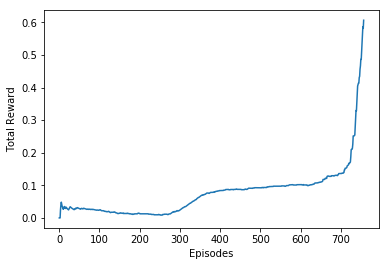

In [12]:
import matplotlib.pyplot as plt
plt.plot(average_reward_history)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()